In [26]:
import nltk
import numpy as np
import json
import pickle
import timeit
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [27]:
devfile = "../A1_Data/dev.json"
trainfile = "../A1_Data/train.json"

### Training Phase

In [28]:
train_labels = []
f = open(trainfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    train_labels.append(json_dump["ratings"])
f.close()

In [39]:
vectorizer = pickle.load(open("baseline_vectorizer.pickle","rb"))

In [45]:
feature_vector = pickle.load(open("baseline_tfidf_train_vector.pickle","rb"))

In [41]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", multi_class='multinomial', solver="saga", max_iter=2000)

In [42]:
start = timeit.default_timer()
model.fit(feature_vector, train_labels)
print(timeit.default_timer()-start)

75.62612305199946


In [43]:
pickle.dump(model,open("baseline_logist_model.pickle", "wb"))

### Some sanity checks

In [ ]:
sanity_check = "Excellent service. The staff is so friendly and always  willing to have conversations with their clients."
check_vector = vectorizer.transform([sanity_check]).toarray()
model.predict(check_vector)[0]

In [ ]:
sanity_check = "Dishonest, untrustworthy, flaw-hiding dealership that is an embarrassment to the brand it bears"
check_vector = vectorizer.transform([sanity_check]).toarray()
model.predict(check_vector)[0]

### Validation phase

In [34]:
dev_feature_vector = pickle.load(open("baseline_tfidf_dev_vector.pickle","rb"))

In [35]:
dev_labels = []
dev_data = []
f = open(devfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    dev_labels.append(json_dump["ratings"])
    dev_data.append(json_dump["review"])
f.close()

In [36]:
conf_mat = np.zeros((5,5), dtype=int)
f = open("error_file","w")
for i in range(0,len(dev_labels),1000):
    fv = dev_feature_vector[i:i+1000]
    y_pred = model.predict(fv)
    conf_mat+= confusion_matrix(y_pred, dev_labels[i:i+1000])
    
    for p in range(1000):
        if  abs(y_pred[p]-dev_labels[i+p])>2:
            f.write("Gold: %.1f, Predicted: %.1f, Review: %s\n"%(dev_labels[i+p], y_pred[p], dev_data[i+p].replace('\n','\\n')))
conf_mat

array([[25256,  5332,  1623,   548,   684],
       [ 2702,  5709,  2702,   446,   136],
       [  780,  3566,  9326,  3580,   612],
       [  295,   914,  6528, 21862,  9940],
       [  756,   618,  1937, 17570, 76578]])

In [37]:
print("Accuracy: \t",conf_mat.trace()/len(dev_data))
score = 0
for i in range(5):
    for j in range(5):
        score+=conf_mat[i][j]*((i-j)**2)
print("Cost: \t\t",score)

Accuracy: 	 0.693655
Cost: 		 114581


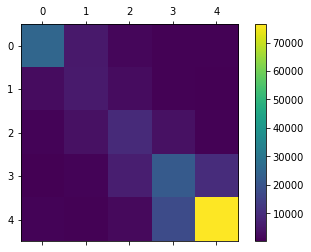

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
fig.colorbar(cax)
plt.savefig("Conf_Mat_Baseline.jpg")